In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import cv2
import netCDF4
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import os

In [2]:
def read_nc_file(file):
    data = netCDF4.Dataset(file)
    data = data['sst4'][:]
    data = np.array(data)
    return data 

In [3]:
def plot_nc_file(file, ax):
    nc_obj = netCDF4.Dataset(file)
    data = nc_obj['sst4'][:]
    min_val , max_val = nc_obj.data_minimum , nc_obj.data_maximum
    new_cmap = colors.ListedColormap(["#93006C","#6F0090","#4800B7","#2100DE","#000AFF","#004AFF","#0090FF","#00D5FF","#00FFD7","#00FF77","#00FF0F","#60FF00","#C8FF00","#FFEB00","#FFB700","#FF8300","#FF4F00","#FF1F00","#E60000","#A50000","#690000"])
    norm= colors.Normalize(vmin=min_val-2, vmax=max_val)
    ax.imshow(data, cmap=new_cmap,norm=norm)
    

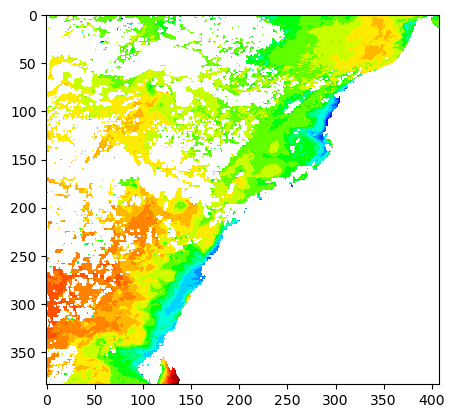

In [4]:
nc_test = "./data/data/images/AQUA_MODIS.20160625_20160702.L3m.8D.SST4.x_sst4.nc"
fig, ax = plt.subplots()
plot_nc_file(nc_test,ax)

In [5]:
def prepere_nc(file):
    data = read_nc_file(file)
    data = data[... , np.newaxis]
    data = data.repeat(3, axis=-1)
    return data

In [6]:
test_out = prepere_nc(nc_test)
test_out.shape

(384, 408, 3)

In [7]:
masks = sorted(os.listdir("data/data/masks/") , key= lambda x : int(x[6:x.find(".")]))
nc_files = os.listdir("data/data/images/")
assert len(masks) == len(nc_files)

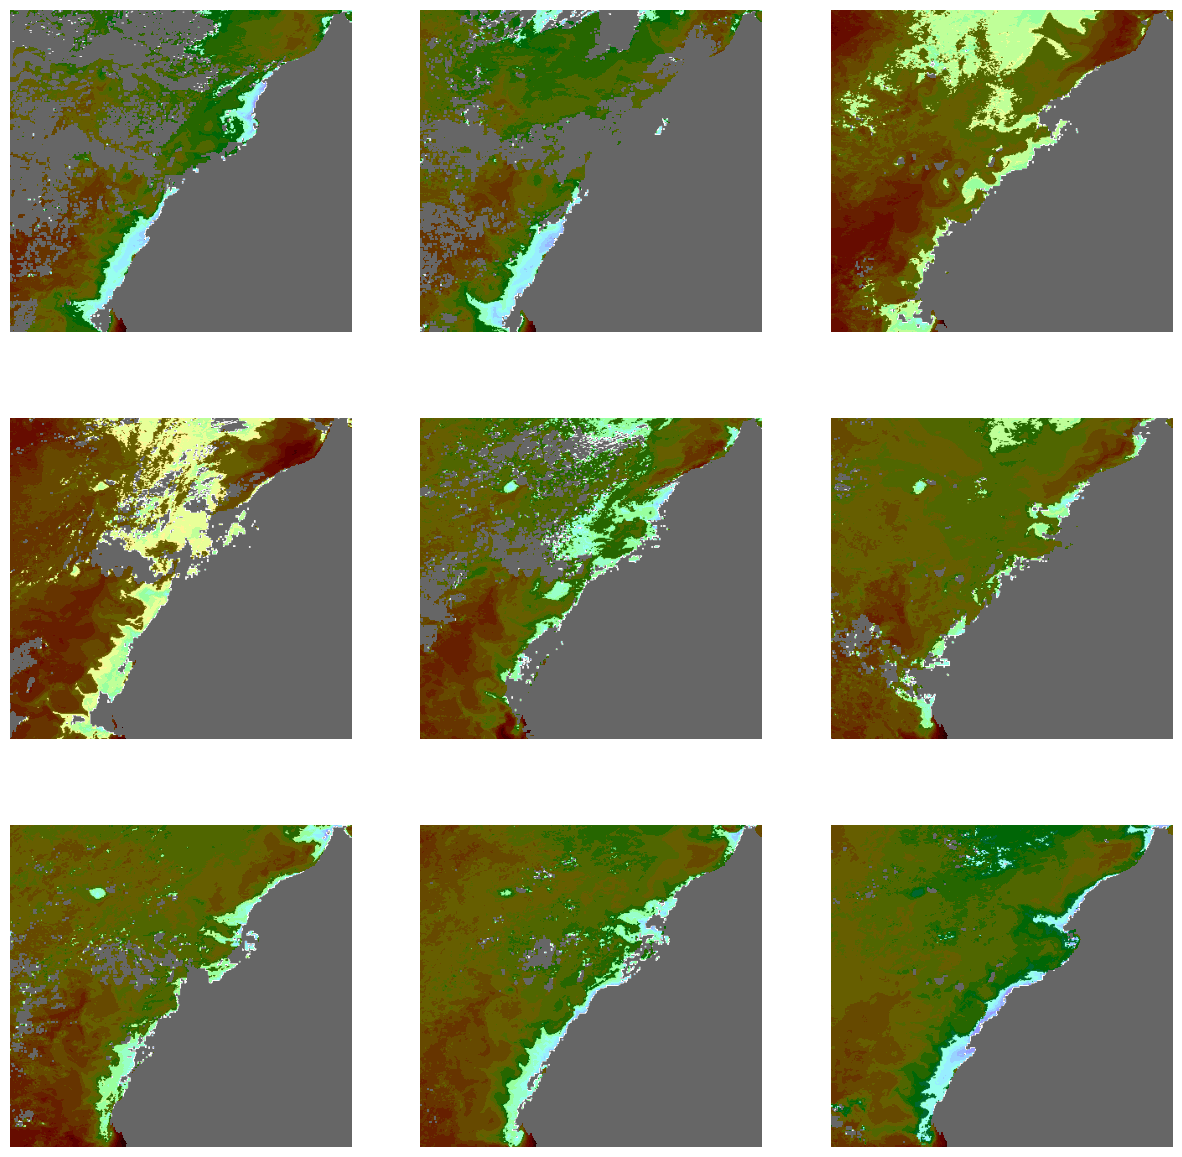

In [8]:
fig, axes = plt.subplots(3, 3,figsize=(15, 15))
axes = axes.flatten()
for i , (file, mask) in enumerate(zip(nc_files, masks)):
    if i == 9:
        break
    plot_nc_file(os.path.join("data/data/images/",file), axes[i])
    mask = plt.imread(os.path.join("data/data/masks/",mask))
    axes[i].imshow(mask, cmap="binary", alpha=0.6)
    axes[i].axis("off")


In [9]:
nc_array = np.array([cv2.resize(prepere_nc(os.path.join("data/data/images/",file)),(512,512)) for file in nc_files])
nc_array.shape

(300, 512, 512, 3)

In [10]:
masks_array = np.array([cv2.resize(cv2.imread(os.path.join("data/data/masks/", file), cv2.IMREAD_GRAYSCALE),(512,512)).astype(bool).astype(int) for file in masks])
masks_array.shape

(300, 512, 512)

In [11]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    x = tf.keras.layers.Dropout(0.5)(x)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s1 = tf.keras.layers.Dropout(0.5)(s1)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s2 = tf.keras.layers.Dropout(0.5)(s2)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s2 = tf.keras.layers.Dropout(0.5)(s2)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)
    b1 = tf.keras.layers.Dropout(0.5)(b1)
    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model


In [12]:
input_shape = (512, 512, 3)
model = build_resnet50_unet(input_shape)

In [13]:
model.summary()

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [14]:
train_len = int(0.9*len(nc_array))
train_len

270

In [27]:
trainset = tf.data.Dataset.from_tensor_slices((nc_array[:train_len], masks_array[:train_len])).prefetch(tf.data.AUTOTUNE).batch(8)
validset = tf.data.Dataset.from_tensor_slices((nc_array[train_len:], masks_array[train_len:])).prefetch(tf.data.AUTOTUNE).batch(4)

In [28]:
for x , y in trainset.take(1):
    print(x.shape)
    print(y.shape)
    break

(8, 512, 512, 3)
(8, 512, 512)


In [29]:
model.compile(optimizer="adam", loss=tf.losses.BinaryCrossentropy(),metrics=["acc",tf.metrics.BinaryCrossentropy()])

In [30]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("model.h5", monitor="val_loss", save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")]

In [31]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [32]:
history = model.fit(x=trainset,  epochs= 10 , validation_data=validset,
                    callbacks=callbacks)

Epoch 1/10
 1/34 [..............................] - ETA: 1:39:29 - loss: 0.9752 - acc: 0.5265 - binary_crossentropy: 0.9752

In [ ]:
res = pd.DataFrame(history.history)

In [ ]:
res[['val_acc', 'acc']].plot(kind ="line")
plt.xlablel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
res[['binary_crossentropy', 'val_binary_crossentropy']].plot(kind ="line")
plt.xlablel("Epochs")
plt.ylabel("loss(cross entropy)")